In [26]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [27]:
# Nelson-Siegel model function
def nelson_siegel(maturities, beta0, beta1, beta2, lambda_):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities)
    term3 = beta2 * ((1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities) - np.exp(-lambda_ * maturities))
    return term1 + term2 + term3


In [28]:
def load_data():

    files={
        'Sri Lanka 3-Month Bond Yield Historical Data.csv':3,
        'Sri Lanka 6-Month Bond Yield Historical Data.csv':6,
        'Sri Lanka 1-Year Bond Yield Historical Data.csv':12,
        'Sri Lanka 2-Year Bond Yield Historical Data.csv':24,
        'Sri Lanka 5-Year Bond Yield Historical Data.csv':60,
    }
    all_data=[]
    for file_name, maturity in files.items():
        data = pd.read_csv(file_name,usecols=['Date','Price'])
        data['Date'] = pd.to_datetime(data['Date'])
        start_date = '2007-01-01'
        end_date = '2024-07-01'
        data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
        data.rename(columns={'Price': 'Yield'}, inplace=True) 
        data['Maturity'] = maturity
        all_data.append(data)
    
    # Concatenate all data into a single DataFrame
    combined_data = pd.concat(all_data)
    
    # Convert 'Date' column to datetime
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])

    # Sort data by Date and Maturity
    combined_data.sort_values(by=['Date', 'Maturity'], inplace=True)

    return combined_data

In [29]:
data=load_data()

In [30]:
data.tail(10)

,Date,Yield,Maturity
1,2024-06-01,10.050,3
2,2024-06-01,10.250,6
2,2024-06-01,10.242,12
2,2024-06-01,11.002,24
2,2024-06-01,11.981,60
0,2024-07-01,10.300,3
1,2024-07-01,9.500,6
1,2024-07-01,10.155,12
1,2024-07-01,10.729,24
1,2024-07-01,12.299,60


In [31]:
selected_date = '2024-07-01'
maturities = data[data['Date'] == selected_date]['Maturity'].values
yields = data[data['Date'] == selected_date]['Yield'].values

In [32]:
maturities

array([ 3,  6, 12, 24, 60], dtype=int64)

In [33]:
yields

array([10.3  ,  9.5  , 10.155, 10.729, 12.299])

In [34]:
initial_guess = [0.03, -0.02, 0.02, 1.0]  # Initial guess for [beta0, beta1, beta2, lambda]
params, _ = curve_fit(nelson_siegel, maturities, yields, p0=initial_guess)
beta0, beta1, beta2, lambda_ = params

C:\Users\Niroshan\AppData\Local\Temp\ipykernel_13948\56247558.py:4: RuntimeWarning: overflow encountered in exp
  term2 = beta1 * (1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities)
C:\Users\Niroshan\AppData\Local\Temp\ipykernel_13948\56247558.py:5: RuntimeWarning: overflow encountered in exp
  term3 = beta2 * ((1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities) - np.exp(-lambda_ * maturities))
C:\Users\Niroshan\AppData\Local\Temp\ipykernel_13948\56247558.py:5: RuntimeWarning: invalid value encountered in subtract
  term3 = beta2 * ((1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities) - np.exp(-lambda_ * maturities))


In [35]:
print(f'Fitted Parameters: Beta0={beta0}, Beta1={beta1}, Beta2={beta2}, Lambda={lambda_}')


Fitted Parameters: Beta0=11.1541021958456, Beta1=-30.286917917987285, Beta2=-87.2969093866488, Lambda=27.067015960254263


In [36]:
future_maturities = np.array([3, 6, 12, 24])  # Future maturities in months
predicted_yields = nelson_siegel(future_maturities, beta0, beta1, beta2, lambda_)

In [37]:
yield_curve_df = pd.DataFrame({'Maturity (Months)': future_maturities, 'Predicted Yield': predicted_yields})
print(yield_curve_df)

   Maturity (Months)  Predicted Yield
0                  3         9.706044
1                  6        10.430073
2                 12        10.792088
3                 24        10.973095


In [38]:
import matplotlib.pyplot as plt

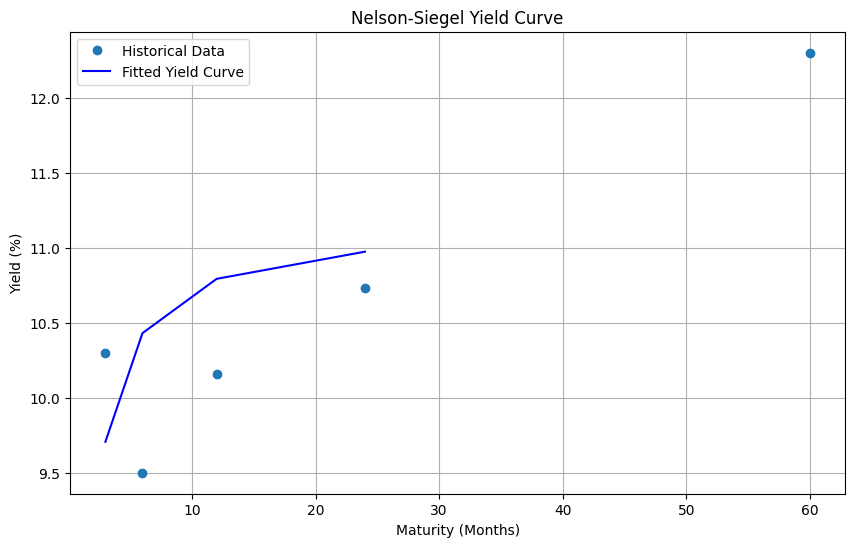

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields, 'o', label='Historical Data')
plt.plot(future_maturities, predicted_yields, label='Fitted Yield Curve', color='blue')
plt.xlabel('Maturity (Months)')
plt.ylabel('Yield (%)')
plt.title('Nelson-Siegel Yield Curve')
plt.legend()
plt.grid()
plt.show()

In [40]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [41]:
def fit_nelson_siegel(data):
    params_list = []
    dates = data['Date'].unique()

    for date in dates:
        date_data = data[data['Date'] == date]
        maturities = date_data['Maturity'].values
        yields = date_data['Yield'].values

        # Initial parameter guesses: [beta0, beta1, beta2, tau]
        initial_guess = [0.03, -0.02, 0.02, 1.0]

        # Fit the model to the data
        params, _ = curve_fit(nelson_siegel, maturities, yields, p0=initial_guess, maxfev=10000)
        params_list.append([date, *params])

    # Convert to DataFrame
    params_df = pd.DataFrame(params_list, columns=['Date', 'beta0', 'beta1', 'beta2', 'tau'])
    print(params_df.head())
    return params_df

In [42]:
def prepare_time_series(data, time_steps=12):
    X, y = [], []

    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])

    return np.array(X), np.array(y)

In [43]:
def train_lstm_model(time_series_data):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(time_series_data)

    # Prepare the data for LSTM
    time_steps = 12  # Use the last 12 months of data to predict the next month
    X, y = prepare_time_series(scaled_data, time_steps)

    # Reshape X to be [samples, time steps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

    return model, scaler

In [44]:
def predict_future_parameters(model, scaler, historical_data, steps=12):
    predictions = []

    # Normalize the historical data
    last_sequence = scaler.transform(historical_data[-12:])  # Last 12 months of data

    for _ in range(steps):
        input_sequence = last_sequence.reshape((1, 12, 1))
        predicted_value = model.predict(input_sequence)
        predictions.append(predicted_value[0, 0])
        last_sequence = np.append(last_sequence[1:], predicted_value, axis=0)

    # Inverse transform to get original scale
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    return predictions.flatten()

In [45]:
data = load_data()

# Fit the Nelson-Siegel model to get historical parameters
params_df = fit_nelson_siegel(data)

# Train separate LSTM models for each parameter (beta0, beta1, beta2, tau)
models = {}
scalers = {}
predictions = {}

for param in ['beta0', 'beta1', 'beta2', 'tau']:
    historical_data = params_df[param].values.reshape(-1, 1)
    model, scaler = train_lstm_model(historical_data)
    models[param] = model
    scalers[param] = scaler
    predictions[param] = predict_future_parameters(model, scaler, historical_data)



C:\Users\Niroshan\AppData\Local\Temp\ipykernel_13948\56247558.py:4: RuntimeWarning: overflow encountered in exp
  term2 = beta1 * (1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities)
C:\Users\Niroshan\AppData\Local\Temp\ipykernel_13948\56247558.py:5: RuntimeWarning: overflow encountered in exp
  term3 = beta2 * ((1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities) - np.exp(-lambda_ * maturities))
C:\Users\Niroshan\AppData\Local\Temp\ipykernel_13948\56247558.py:5: RuntimeWarning: invalid value encountered in subtract
  term3 = beta2 * ((1 - np.exp(-lambda_ * maturities)) / (lambda_ * maturities) - np.exp(-lambda_ * maturities))
c:\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Niroshan\AppData\Local\Temp\ipykernel_13948\56247558.py:4: RuntimeWarning: overflow encountered in multiply
  term2 = beta1 * (1 - np

        Date      beta0         beta1         beta2          tau
0 2007-01-01  13.717792   -107.277187   -146.483546   193.623969
1 2007-02-01  14.058324    490.612962    404.192002  3165.525957
2 2007-03-01  14.147534      1.604857     19.291785    12.264056
3 2007-04-01  13.804803 -89287.187121  89333.792464     3.622549
4 2007-05-01  14.288666 -91204.956896  91254.021985     3.593127
Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0099 - val_loss: 4.9071e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0105 - val_loss: 3.8188e-05
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072 - val_loss: 3.3514e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0209 - val_loss: 1.5045e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0099 - val_loss: 3.5339e-05
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0259 - val_loss: 3.0210e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0280 - val_loss: 1.0270e-04
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0126 - val_loss: 3.5639e-05
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - val_loss: 2.4027e-04
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0108 - val_loss: 2.9775e-04
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091 - val_loss: 6.5608e-05
Epoch 12/50
10/10 ━━━━━━━━━━━━

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.4160 - val_loss: 0.0369
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0295 - val_loss: 0.0339
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0073 - val_loss: 0.0365
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0037 - val_loss: 0.0413
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0030 - val_loss: 0.0331
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0017 - val_loss: 0.0340
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.5511e-04 - val_loss: 0.0342
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.9916e-04 - val_loss: 0.0336
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.5022e-04 - val_loss: 0.0342
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.4462e-04 - val_loss: 0.0337
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.1163e-04 - val_loss: 0.0340
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0171 - val_loss: 0.0340
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0026 - val_loss: 0.0358
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.4287e-04 - val_loss: 0.0317
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.2247e-04 - val_loss: 0.0321
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.6149e-05 - val_loss: 0.0324
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.9685e-04 - val_loss: 0.0320
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.9400e-04 - val_loss: 0.0322
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.1395e-04 - val_loss: 0.0321
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.9889e-04 - val_loss: 0.0321
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.4836e-04 - val_loss: 0.0322
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.2132e-04 - val_loss: 0.0321
Epoch 12/50
10/10 ━━━━━━━

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 3.4588e-04 - val_loss: 3.7933e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.4012e-04 - val_loss: 3.8351e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.3911e-04 - val_loss: 3.8295e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.5862e-04 - val_loss: 3.9734e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.3072e-04 - val_loss: 3.9062e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.3736e-04 - val_loss: 3.8962e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.9063e-04 - val_loss: 3.9484e-04
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.3685e-04 - val_loss: 3.8710e-04
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 4.6570e-04 - val_loss: 3.8914e-04
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.5173e-04 - val_loss: 3.9609e-04
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.9538e

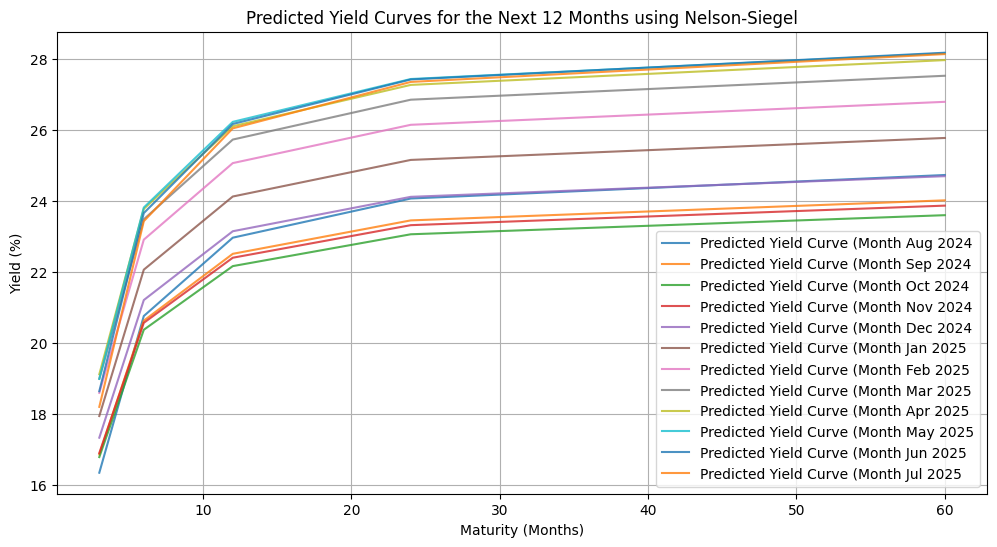

In [47]:
# Predict the yield curve for the next 12 months using the predicted parameters
future_maturities = np.array([3, 6, 12, 24, 60])  # Maturities in months

# Plot the predicted yield curves for the next 12 months
plt.figure(figsize=(12, 6))
months = pd.date_range(start='2024-08-01', periods=12, freq='M')
for month in range(12):
    next_month_params = [predictions['beta0'][month], predictions['beta1'][month], predictions['beta2'][month], predictions['tau'][month]]
    predicted_yields_next_month = nelson_siegel(future_maturities, *next_month_params)
    plt.plot(future_maturities, predicted_yields_next_month, label=f'Predicted Yield Curve (Month {months[month].strftime("%b %Y")}', alpha=0.8)

plt.xlabel('Maturity (Months)')
plt.ylabel('Yield (%)')
plt.title('Predicted Yield Curves for the Next 12 Months using Nelson-Siegel')
plt.legend()
plt.grid()
plt.show()

In [48]:
print(params_df)

          Date      beta0         beta1         beta2          tau
0   2007-01-01  13.717792   -107.277187   -146.483546   193.623969
1   2007-02-01  14.058324    490.612962    404.192002  3165.525957
2   2007-03-01  14.147534      1.604857     19.291785    12.264056
3   2007-04-01  13.804803 -89287.187121  89333.792464     3.622549
4   2007-05-01  14.288666 -91204.956896  91254.021985     3.593127
..         ...        ...           ...           ...          ...
206 2024-03-01  11.748085    -43.084067    -52.130729    15.668001
207 2024-04-01  11.594820    -88.222108    -59.752024    20.480596
208 2024-05-01  10.749892    -93.274892    -42.104666    19.362396
209 2024-06-01  11.291039    -77.859688    -83.904778    35.423878
210 2024-07-01  11.154102    -30.286918    -87.296909    27.067016

[211 rows x 5 columns]


In [49]:
print(predictions['beta0'])

[25.168015 24.390112 23.954319 24.231318 25.08115  26.181633 27.218246
 27.969511 28.42725  28.635208 28.671064 28.654163]


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, scaler, X_test, y_test):
    # Predict on the test data
    predictions = model.predict(X_test)
    
    # Inverse transform the predictions and actual values to original scale
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Compute performance metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    print(predictions[0],y_test[0])
    
    return mae, mse, rmse

# Evaluate each LSTM model
for param in ['beta0', 'beta1', 'beta2', 'tau']:
    model = models[param]
    scaler = scalers[param]
    historical_data = params_df[param].values.reshape(-1, 1)
    
    # Prepare time series data for evaluation
    time_steps = 12
    X, y = prepare_time_series(historical_data, time_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[train_size:], X[:train_size]
    y_train, y_test = y[train_size:], y[:train_size]
    
    # Evaluate the model
    mae, mse, rmse = evaluate_model(model, scaler, X_test, y_test)
    
    print(f"Evaluation for {param}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
[-417.75308] [11212.42772646]
Evaluation for beta0:
Mean Absolute Error (MAE): 44278.8050
Mean Squared Error (MSE): 34044430024.9891
Root Mean Squared Error (RMSE): 184511.3276

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
[-83977.734] [4257783.82606921]
Evaluation for beta1:
Mean Absolute Error (MAE): 364406602.6699
Mean Squared Error (MSE): 9910934694192379904.0000
Root Mean Squared Error (RMSE): 3148163701.9368

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
[32987.367] [5732015.57014951]
Evaluation for beta2:
Mean Absolute Error (MAE): 369133808.4384
Mean Squared Error (MSE): 9928011460432748544.0000
Root Mean Squared Error (RMSE): 3150874713.5411

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
[8585.113] [97.2194603]
Evaluation for tau:
Mean Absolute Error (MAE): 101236.9865
Mean Squared Error (MSE): 59153319806.4416
Root Mean Squared Error (RMSE): 243214.5551

